In [17]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
import seaborn as sns

from pymmmc import GammaGamma

In [2]:
rng = np.random.default_rng(34)

# Hyperparameters
p_true = 6.
q_true = 4.
γ_true = 15.

# Number of subjects
N = 2_000

x = rng.poisson(lam=2, size=(N)) + 1
data = GammaGamma.rv_op.rng_fn(rng, p_true, q_true, γ_true, x, size=None)

In [62]:
def f(p, q, γ, N):
    # Subject level parameters
    nu_true = pm.draw(pm.Gamma.dist(q, γ, size=N), random_seed=rng)

    # Number of observations per subject
    x_2 = rng.poisson(lam=2, size=N) + 1  
    idx = np.repeat(np.arange(0, N), x_2)
    # Observations
    z_2 = pm.draw(pm.Gamma.dist(p, nu_true[idx]), random_seed=rng)
    
    df = pd.DataFrame(data={"z": z_2, "id": idx})
    z_mean = df.groupby("id").mean()["z"].values
    
    return x_2, z_mean

In [63]:
x_2, z_2 = f(p_true, q_true, γ_true, N)

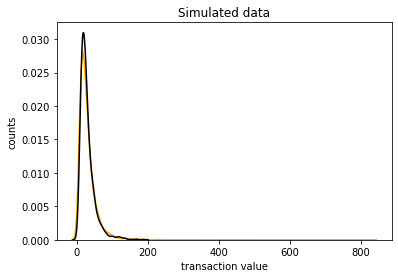

In [60]:
sns.kdeplot(z_2, c="orange")
sns.kdeplot(data, c="k")
plt.xlabel("transaction value")
plt.ylabel("counts")
plt.title("Simulated data");

### Inference on $\overline{z}$

In [64]:
with pm.Model() as m2:
    p = pm.HalfFlat("p")
    q = pm.HalfFlat("q")
    γ = pm.HalfFlat("γ")

    gg = GammaGamma("gamma-gamma", p, q, γ, x_2, observed=z_2)
    
    trace = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'q'}>,
        <AxesSubplot:title={'center':'q'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

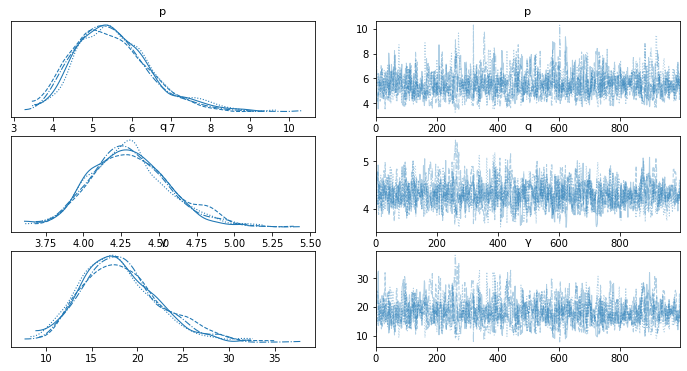

In [65]:
az.plot_trace(trace)

In [66]:
az.summary(trace, var_names=["p", "q", "γ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,5.545,0.982,3.718,7.312,0.036,0.026,715.0,1060.0,1.0
q,4.309,0.261,3.859,4.843,0.009,0.006,825.0,1188.0,1.0
γ,18.138,4.243,10.718,26.289,0.165,0.116,667.0,967.0,1.0


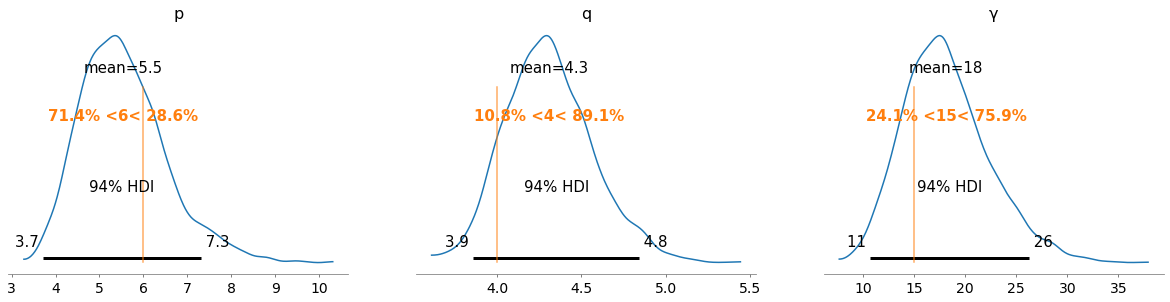

In [67]:
az.plot_posterior(trace, var_names=["p", "q", "γ"], ref_val=[p_true, q_true, γ_true]);

### Gamma-Gamma model with $\nu$ marginalized

In [10]:
with pm.Model() as m3:
    p = pm.HalfFlat("p")
    q = pm.HalfFlat("q")
    γ = pm.HalfFlat("γ")  

    # Likelihood of z_bar, marginalizing over ν
    likelihood = pm.Potential(
        "likelihood", 
        (
            at.gammaln(p * x + q)
            - at.gammaln(p * x)
            - at.gammaln(q)
            + q * at.log(γ)
            + (p * x - 1) * at.log(z_bar)
            + (p * x) * at.log(x)
            - (p * x + q) * at.log(x * z_bar + γ)
        ),
    )
    
    trace3 = pm.sample()

NameError: name 'at' is not defined

In [ ]:
az.summary(trace3, var_names=["p", "q", "γ"])

In [ ]:
az.plot_posterior(trace3, var_names=["p", "q", "γ"], ref_val=[p_true, q_true, γ_true]);

### Sanity check

In [ ]:
n = 10_000
g1 = pm.draw(pm.Gamma.dist(3, 2, size=n))
g2 = pm.draw(pm.Gamma.dist(5, 2, size=n))
g_sum = pm.draw(pm.Gamma.dist(3+5, 2, size=n))
g_mean = pm.draw(pm.Gamma.dist(3+5, 4, size=n))

In [ ]:
bins = np.linspace(0, 15, 100)
plt.hist((g1 + g2), bins=bins, ec="k", alpha=0.5)
plt.hist(g_sum, bins=bins, ec="k", alpha=0.5);

In [ ]:
bins = np.linspace(0, 7, 100)
plt.hist((g1 + g2) / 2, bins=bins, ec="k", alpha=0.5)
plt.hist(g_mean, bins=bins, ec="k", alpha=0.5);